In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\hp\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
con= sqlite3.connect('database.sqlite')

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score !=3 """,con)

def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

actualScore = filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data['Score']= positiveNegative

In [5]:
print(filtered_data.shape)

(525814, 10)


In [6]:
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [9]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [11]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [16]:
print(final.shape)

final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [17]:
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

6
I set aside at least an hour each day to read to my son (3 y/o). At this point, I consider myself a connoisseur of children's books and this is one of the best. Santa Clause put this under the tree. Since then, we've read it perpetually and he loves it.<br /><br />First, this book taught him the months of the year.<br /><br />Second, it's a pleasure to read. Well suited to 1.5 y/o old to 4+.<br /><br />Very few children's books are worth owning. Most should be borrowed from the library. This book, however, deserves a permanent spot on your shelf. Sendak's best.


In [18]:
stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('#######################################')
print(sno.stem('tasty'))

{'theirs', 'during', 'was', "aren't", 'through', 'any', 'yourselves', 'had', 'until', 'for', 'other', 'shan', "it's", "haven't", 'those', "didn't", 'is', 'does', 'below', 'after', 'mightn', 'been', 'doing', 'himself', 'but', 'under', 'shouldn', 'very', 'this', 'where', 'my', "hasn't", 'all', 'isn', "don't", 'here', "wouldn't", 'do', 'by', 'mustn', 've', 'ourselves', 'didn', 'off', 'should', 'yourself', 'just', 'myself', 'only', 'won', 'why', 'your', 'now', 'it', 'wouldn', 'hadn', 't', 'll', 'before', 'an', 's', 'so', 'did', "shan't", 'herself', 'has', 'or', 'into', 'ma', 'when', 'o', 'our', 'yours', 'few', 'too', 'if', "mightn't", "won't", 'him', 'she', 'as', 'what', 'we', 'and', 'not', "should've", "isn't", 'were', 'above', 'its', "you're", 'you', 'being', 'haven', 'over', 'from', 'i', 'own', 'hers', 'again', 'am', "doesn't", 'can', 'having', "that'll", 'they', 'themselves', 'each', 'hasn', 'me', "mustn't", 'be', 'some', 'up', "you'd", 'his', 'couldn', "she's", "you've", 'ain', "you'l

In [19]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [20]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [21]:
final.head(3) #below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn,  schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

In [22]:
#Taking first 1k positive and first 1k negative
data_p=final[final['Score']=='positive'].head(n = 1000)
data_n=final[final['Score']=='negative'].head(n = 1000)
final_2k=pd.concat([data_p, data_n])

In [23]:
Score_2k=final_2k['Score']

In [25]:
print(final_2k.shape)
print(Score_2k.shape)

(2000, 11)
(2000,)


In [26]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(final_2k['CleanedText'].values)


In [27]:
print("the type of count vectorizer ",type(final_counts))
print("the shape of our text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our text BOW vectorizer  (2000, 7125)
the number of unique words  7125


In [28]:
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'like', 139429), (b'tast', 129047), (b'good', 112766), (b'flavor', 109624), (b'love', 107357), (b'use', 103888), (b'great', 103870), (b'one', 96726), (b'product', 91033), (b'tri', 86791), (b'tea', 83888), (b'coffe', 78814), (b'make', 75107), (b'get', 72125), (b'food', 64802), (b'would', 55568), (b'time', 55264), (b'buy', 54198), (b'realli', 52715), (b'eat', 52004)]
Most Common Negative Words :  [(b'tast', 34585), (b'like', 32330), (b'product', 28218), (b'one', 20569), (b'flavor', 19575), (b'would', 17972), (b'tri', 17753), (b'use', 15302), (b'good', 15041), (b'coffe', 14716), (b'get', 13786), (b'buy', 13752), (b'order', 12871), (b'food', 12754), (b'dont', 11877), (b'tea', 11665), (b'even', 11085), (b'box', 10844), (b'amazon', 10073), (b'make', 9840)]


In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final_2k['CleanedText'].values)


In [30]:
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (2000, 74930)
the number of unique words including both unigrams and bigrams  74930


In [31]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_bigram_counts)
std_data.shape

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(2000, 74930)

In [32]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [33]:
# convert sparse to dense as tsne takes dense vector

std_data = std_data.toarray()

In [34]:
type(std_data)

numpy.ndarray

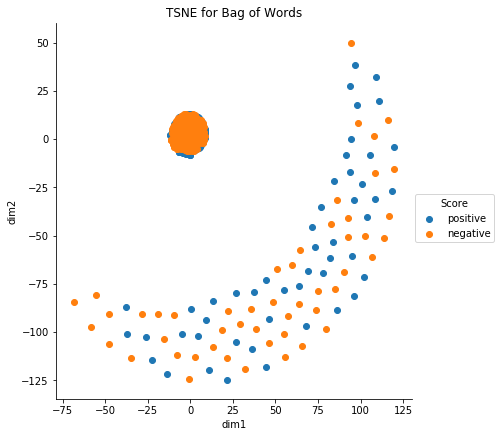

In [35]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)
# configuring the parameteres
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations for the optimization = 1000

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Bag of Words")
plt.show()

TF_IDF

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_2k['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (2000, 74930)
the number of unique words including both unigrams and bigrams  74930


In [37]:
from sklearn.preprocessing import StandardScaler

std_data = StandardScaler(with_mean = False).fit_transform(final_tf_idf)


In [38]:
std_data.shape

(2000, 74930)

In [39]:
type(std_data)

scipy.sparse.csr.csr_matrix

In [40]:
std_data=std_data.toarray()

In [41]:
type(std_data)

numpy.ndarray

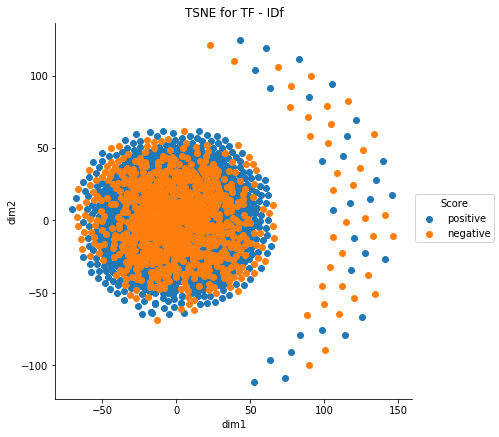

In [42]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, perplexity = 50)

tsne_data = model.fit_transform(std_data)


# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, Score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF - IDf")
plt.show()

avg w2v

In [43]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import gensim

#train your own w2v model using your own corpus

list_of_sent = []
for sent in final_2k['Text'].values:
    filtered_sentence = []
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [46]:
print(final_2k['Text'].values[5])
print("*****************************************************************")
print(list_of_sent[5])

A charming, rhyming book that describes the circumstances under which you eat (or don't) chicken soup with rice, month-by-month. This sounds like the kind of thing kids would make up while they're out of recess and sing over and over until they drive the teachers crazy. It's cute and catchy and sounds really childlike but is skillfully written.
*****************************************************************
['a', 'charming', 'rhyming', 'book', 'that', 'describes', 'the', 'circumstances', 'under', 'which', 'you', 'eat', 'or', 'dont', 'chicken', 'soup', 'with', 'rice', 'this', 'sounds', 'like', 'the', 'kind', 'of', 'thing', 'kids', 'would', 'make', 'up', 'while', 'theyre', 'out', 'of', 'recess', 'and', 'sing', 'over', 'and', 'over', 'until', 'they', 'drive', 'the', 'teachers', 'crazy', 'its', 'cute', 'and', 'catchy', 'and', 'sounds', 'really', 'childlike', 'but', 'is', 'skillfully', 'written']


In [47]:
len(list_of_sent)

2000

In [48]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

In [49]:
w2v = w2v_model[w2v_model.wv.vocab]

In [50]:
w2v.shape

(2900, 50)

In [51]:
words = list(w2v_model.wv.vocab)
print(len(words))

2900


In [52]:
w2v_model.wv.most_similar('tasty')

[('pretty', 0.9985558390617371),
 ('sweet', 0.9984210729598999),
 ('quality', 0.9981987476348877),
 ('nice', 0.9981351494789124),
 ('tastes', 0.9979822635650635),
 ('healthy', 0.9979109764099121),
 ('color', 0.9978674650192261),
 ('cheap', 0.9978403449058533),
 ('expensive', 0.9978253245353699),
 ('true', 0.9978066682815552)]

In [53]:
w2v_model.wv.most_similar('like')

[('but', 0.9946737885475159),
 ('need', 0.9918225407600403),
 ('buy', 0.9916343092918396),
 ('really', 0.9911943674087524),
 ('sure', 0.9910017848014832),
 ('think', 0.9909423589706421),
 ('make', 0.9909103512763977),
 ('wont', 0.9906368851661682),
 ('may', 0.989059329032898),
 ('unless', 0.9890059232711792)]

avg w2v

In [55]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))




2000
50


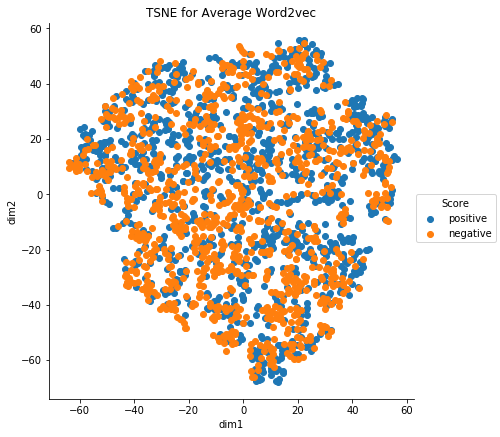

In [57]:
#tsne

from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 30, n_iter = 5000)

tsne_data = model.fit_transform(sent_vectors)

tsne_data = np.vstack((tsne_data.T, Score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=6).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for Average Word2vec")
plt.show()

TF-IDF w2v

In [58]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idfidf of a word in a sentence/review
            tf_idf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
        except:
            pass
    sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

In [59]:
# To know length of tfidf vector
len(tfidf_sent_vectors)

2000

In [60]:
np.isnan(tfidf_sent_vectors)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [61]:
# To replace nan with 0 and inf with large finite number

tfidf_sent_vectors = np.nan_to_num(tfidf_sent_vectors)

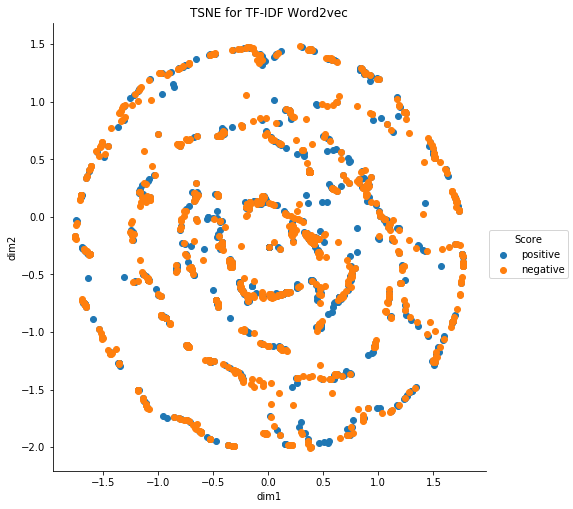

In [62]:
#tsne
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0, perplexity = 50, n_iter = 5000)

tsne_data = model.fit_transform(tfidf_sent_vectors)

tsne_data = np.vstack((tsne_data.T, Score_2k)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("dim1", "dim2", "Score"))

# Ploting the result of tsne
sns.FacetGrid(tsne_df, hue="Score", size=7).map(plt.scatter, 'dim1', 'dim2').add_legend()
plt.title("TSNE for TF-IDF Word2vec")
plt.show()

# Obsevations:
By looking at all tsne reprentation, none of these gives well separated positive and negative reviews.